In [173]:
import tensorflow as tf
import glob
import os

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_train\*.png"))
seg_train_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_train\*.png"))

test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_test\*.png"))
seg_test_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_test\*.png"))

val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_validate\*.png"))
seg_val_dir = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_validate\*.png"))

In [174]:
train = tf.data.Dataset.from_tensor_slices((train_dir, seg_train_dir))
test = tf.data.Dataset.from_tensor_slices((test_dir, seg_test_dir))
val = tf.data.Dataset.from_tensor_slices((val_dir, seg_val_dir))

train = train.shuffle(len(train_dir))
test = test.shuffle(len(test_dir))
val = val.shuffle(len(val_dir))

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.image.resize(img, (256,256))
    return img

def process_path(img_path, mask_path):
    img = decode_img(img_path)
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = decode_img(mask_path)
    mask = mask == [0, 85, 170, 255]
    mask = tf.cast(mask, tf.int32)
    return img, mask

train = train.map(process_path)
test = test.map(process_path)
val = val.map(process_path)
count = 0

print(train)

<MapDataset shapes: ((256, 256, 1), (256, 256, 4)), types: (tf.float32, tf.int32)>


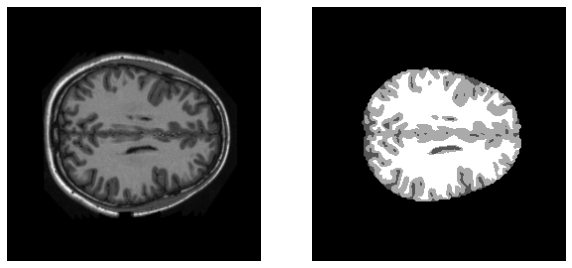

In [175]:
import matplotlib.pyplot as plt 

def display(images):
    plt.figure(figsize=(10,10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.imshow(images[i], cmap = 'gray')
        plt.axis('off')
    plt.show()
    
for img, mask in train.take(1):
    display([tf.squeeze(img), tf.argmax(mask, axis = -1)])

In [179]:
from tensorflow.keras import layers

image_res = (256,256)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(image_res[0] // 8 * image_res[1] // 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((image_res[0] // 8, image_res[1] // 8, 256)))
    
    assert model.output_shape == (None, image_res[0] // 8, image_res[1] // 8, 256)

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 4, image_res[1] // 4, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    
    assert model.output_shape == (None, image_res[0] // 2, image_res[1] // 2, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    assert model.output_shape == (None, image_res[0], image_res[1], 1)
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[image_res[0], image_res[1], 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# generator.summary()
# discriminator.summary()

In [180]:
generator = make_generator_model()
discriminator = make_discriminator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)

print (decision)

ResourceExhaustedError: OOM when allocating tensor with shape[100,262144] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]